## Agrupando automóveis

In [1]:
# Imports
import math
import pandas as pd
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Spark Session - usada quando se trabalha com Dataframes no Spark
spSession = SparkSession.builder.master("local").appName("DSA-SparkMLLib").getOrCreate()

In [3]:
# Carregando os dados e gerando um RDD
carrosRDD = sc.textFile("data/carros2.csv")
carrosRDD.cache()

data/carros2.csv MapPartitionsRDD[1] at textFile at <unknown>:0

In [4]:
# Removendo a primeira linha do arquivo (cabeçalho)
primeiraLinha = carrosRDD.first()
carrosRDD2 = carrosRDD.filter(lambda x: x != primeiraLinha)
carrosRDD2.count()

197

In [5]:
carrosRDD2.take(5)

['subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389']

In [6]:
# Convertendo e limpando os dados
def transformToNumeric( inputStr) :
    attList = inputStr.split(",")

    doors = 1.0 if attList[3] == "two" else 2.0
    body = 1.0 if attList[4] == "sedan" else 2.0 
       
    linhas = Row(DOORS = doors, BODY = float(body), HP = float(attList[7]), RPM = float(attList[8]),
                 MPG = float(attList[9]))
    return linhas

In [7]:
# Aplicando a função
carrosRDD3 = carrosRDD2.map(transformToNumeric)
carrosRDD3.persist()
carrosRDD3.take(5)

[Row(DOORS=1.0, BODY=2.0, HP=69.0, RPM=4900.0, MPG=31.0),
 Row(DOORS=1.0, BODY=2.0, HP=48.0, RPM=5100.0, MPG=47.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5000.0, MPG=30.0),
 Row(DOORS=1.0, BODY=2.0, HP=62.0, RPM=4800.0, MPG=35.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=37.0)]

In [8]:
# Criando um Dataframe
carrosDF = spSession.createDataFrame(carrosRDD3)
carrosDF.show()

+-----+----+----+------+----+
|DOORS|BODY|  HP|   RPM| MPG|
+-----+----+----+------+----+
|  1.0| 2.0|69.0|4900.0|31.0|
|  1.0| 2.0|48.0|5100.0|47.0|
|  1.0| 2.0|68.0|5000.0|30.0|
|  1.0| 2.0|62.0|4800.0|35.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|60.0|5500.0|38.0|
|  1.0| 1.0|69.0|5200.0|31.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5000.0|31.0|
|  1.0| 2.0|68.0|5500.0|31.0|
|  2.0| 2.0|68.0|5500.0|31.0|
|  2.0| 2.0|68.0|5500.0|31.0|
|  1.0| 2.0|70.0|5400.0|38.0|
|  1.0| 2.0|62.0|4800.0|31.0|
|  1.0| 2.0|68.0|5500.0|31.0|
|  1.0| 2.0|58.0|4800.0|49.0|
|  2.0| 2.0|62.0|4800.0|31.0|
|  1.0| 2.0|76.0|6000.0|30.0|
|  2.0| 1.0|70.0|5400.0|38.0|
+-----+----+----+------+----+
only showing top 20 rows



In [9]:
# Sumarizando os dados e extraindo a média e o desvio padrão
estats = carrosDF.describe().toPandas()
medias = estats.iloc[1,1:5].values.tolist()
desvios = estats.iloc[2,1:5].values.tolist()

In [10]:
# Colocando a média e o desvio padrão e variáves do tipo Broadcast
bc_media = sc.broadcast(medias)
bc_desvio = sc.broadcast(desvios)

In [11]:
# Função para centralizar e aplicar escala aos dados. Cada valor será subtraído da média então dividido pelo desvio padrão
def centerAndScale(inRow) :
    global bc_media
    global bc_desvio
    
    meanArray = bc_media.value
    stdArray = bc_desvio.value

    retArray = []
    
    for i in range(len(meanArray)):
        retArray.append( (float(inRow[i]) - float(meanArray[i])) / float(stdArray[i]) )
    return Vectors.dense(retArray)

In [12]:
carrosRDD4 = carrosDF.rdd.map(centerAndScale)
carrosRDD4.collect()

[DenseVector([-1.145, 0.9337, -0.9194, -0.4532]),
 DenseVector([-1.145, 0.9337, -1.4773, -0.0375]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -1.1585, 0.7941]),
 DenseVector([-1.145, -1.0656, -0.9194, 0.1704]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([0.869, 0.9337, -0.9459, 0.7941]),
 DenseVector([0.869, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -0.8928, 0.5862]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -1.2116, -0.6611]),
 DenseVector([0.869, 0.9337, -1.1053, -0.6611]),
 DenseVector([-1.145, 0.9337, -0.7334, 1.8335]),
 DenseVector([0.869, -1.0656, -0.8928, 0.5862]),
 DenseVector([

In [13]:
# Criando um Dataframe
carrosRDD5 = carrosRDD4.map( lambda f:Row(features = f))
carrosDF = spSession.createDataFrame(carrosRDD5)
carrosDF.select("features").show(10)

+--------------------+
|            features|
+--------------------+
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
+--------------------+
only showing top 10 rows



In [14]:
# Criando o modelo
kmeans = KMeans(k = 3, seed = 1)
modelo = kmeans.fit(carrosDF)

In [15]:
# Previsões
previsoes = modelo.transform(carrosDF)
previsoes.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[0.86895117361793...|         0|
|[0.86895117361793...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[0.86895117361793...|         0|
|[-1.1449709581789...|         0|
|[0.86895117361793...|         1|
+--------------------+----------+
only showing top 20 rows



In [16]:
def unstripData(instr) :
    return (instr["prediction"], instr["features"][0], instr["features"][1], instr["features"][2], instr["features"][3])

In [17]:
carrosRDD6 = previsoes.rdd.map(unstripData)
predList = carrosRDD6.collect()
predPd = pd.DataFrame(predList)

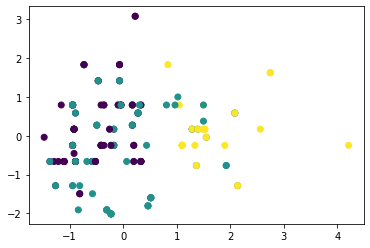

In [18]:
# Gráfico com o resultados dos clusters criados
plt.cla()
plt.scatter(predPd[3], predPd[4], c = predPd[0])